In [1]:
from fit_completeness_to_catalog import *
import os
name = "barclay"
cut_to_Ms = True
nwalkers = 24
ndim = 8
%load_ext autoreload
%autoreload 2

Selected 352 stars


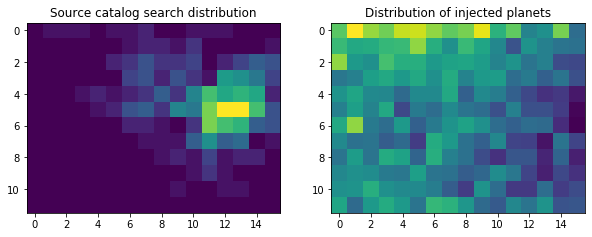

Injected 12399 transiting planets


In [2]:
catalog, num_stars = get_catalog_and_numstars(name, cut_to_Ms)
num_stars = 200000
# use the number of stars that were considered as TESS targets
if os.path.isfile('synth{}.h5'.format(str(num_stars))):
    synth = pd.read_hdf('synth{}.h5'.format(str(num_stars)))
else:
    print("Making synth solar systems")
    synth = make_synth_solar_systems(num_stars=num_stars)
    synth.to_hdf('synth{}.h5'.format(str(num_stars)), key='synth')
synth = synth[synth.transit_bool]
hist_synth, hist_catalog = make_hists(synth, catalog)
print("Injected {} transiting planets".format(int(np.sum(hist_synth))))

In [3]:
!pip show scipy

Name: scipy
Version: 1.5.1
Summary: SciPy: Scientific Library for Python
Home-page: https://www.scipy.org
Author: None
Author-email: None
License: BSD
Location: /usr/local/lib/python3.7/site-packages
Requires: numpy
Required-by: Theano, tensorflow, speclite, scikit-learn, scikit-image, radvel, pymc3, oktopus, lightkurve, lightcurve, lalsuite, isochrones, healpy, gwpy, arviz, aotools


In [18]:
ll, p0 = make_mcmc_setup(hist_synth, hist_catalog, nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, ll)

_ = sampler.run_mcmc(p0, 10000, progress="notebook")
sampler.reset()
pos, _, _ = sampler.run_mcmc(p0, 50000, store=True, progress="notebook")

Found least-squares solution: [ 3.68554356e-03 -1.42177675e-02  1.99802303e-04  2.45849950e-03
  3.36362109e-02  1.07857829e+00  9.03202174e-01  4.31375331e-01]
Set initial condition


In [20]:
i = 0
while True:
    try:
        print(sampler.get_autocorr_time())
        break
    except BaseException:
        sampler.run_mcmc(p0, 1000, store=True)
        print(i)
        i += 1

0
1


KeyboardInterrupt: 

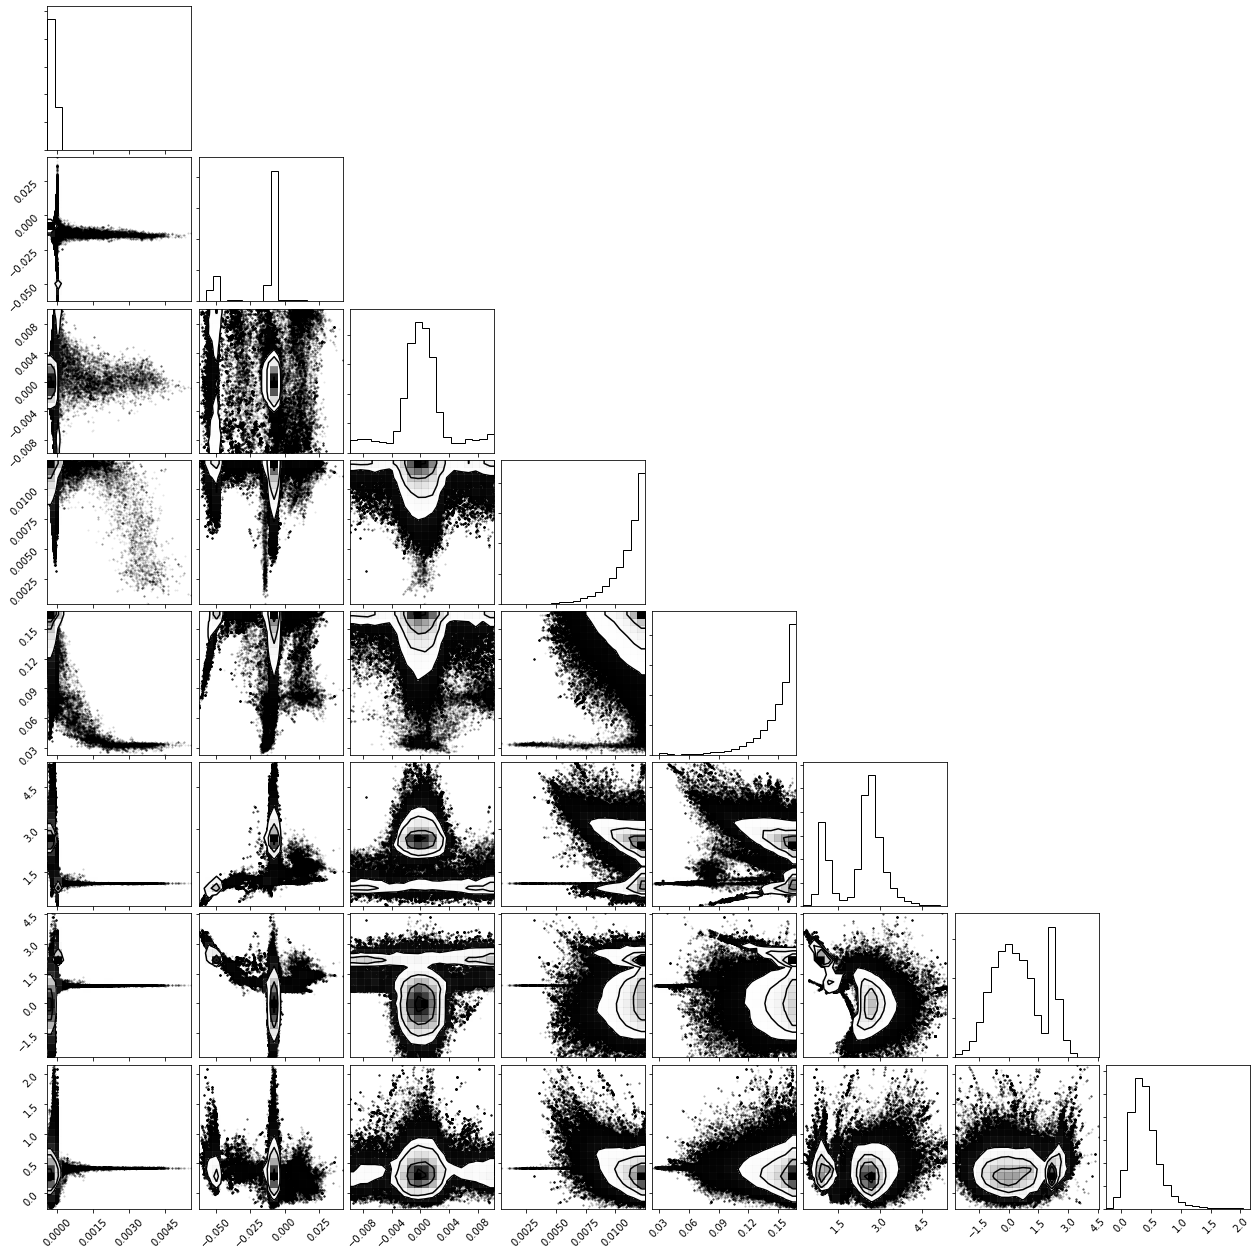

In [21]:
_ = corner.corner(sampler.flatchain)

In [22]:
ll(np.mean(sampler.flatchain[:-10000],axis=0))

-500.7673375625866

In [23]:
from IPython.display import display, Math
labels = ['p0', 'p1', 'p2', 'p3', 'r0', 'r1', 'r2', 'r3']

best_params = np.empty(ndim,)
for i in range(ndim):
    mcmc = np.percentile(sampler.get_chain(discard=100, thin=15, flat=True)[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    best_params[i] = mcmc[1]
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

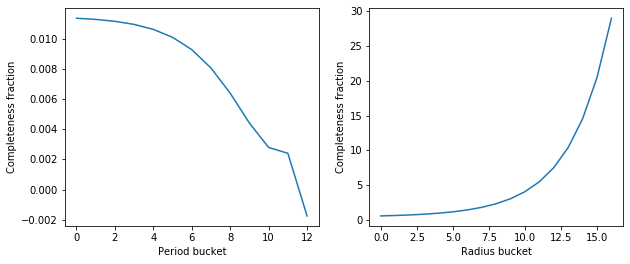

In [24]:
plot_marginalized_comps(best_params)

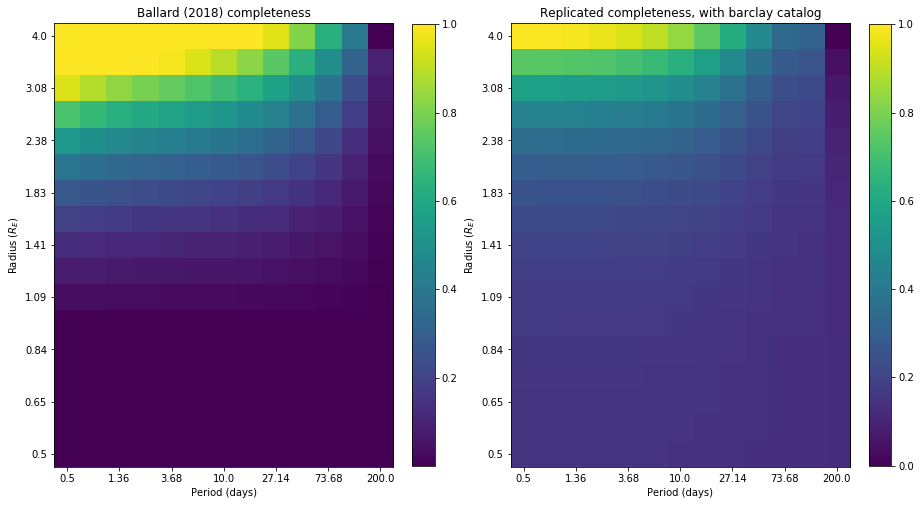

In [25]:
repcomp = np.outer(comp_poly(bins_p, *best_params[:4]), comp_poly(bins_r, *best_params[4:])).T
repcomp -= np.min(repcomp)
repcomp /= np.max(repcomp)
plot_overall_comps(repcomp, name)